# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 10
## Ensembling large models with augmentation sets selected in Experiment 5, Early Stopping/Model Saving and Oversampling

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
trn_path = path/'corn'/'train'
# trn_path.ls()

In [6]:
tst_path = path/'corn'/'test'
# tst_path.ls()

Grab csv lists

In [7]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
trn_files = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
tst_files = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

In [8]:
print(trn_files.head())

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


In [9]:
trn_files['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

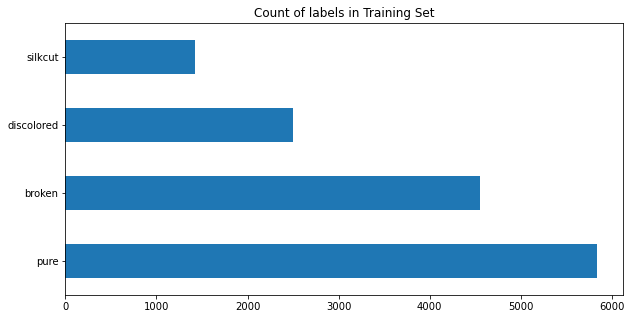

In [10]:
trn_files['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
import pickle

class OversampleDataloaderGenerator:
    def oversample(self):
        max_size = self.train_df['label'].value_counts().max()
        lst = [self.train_df]
        for class_index, group in self.train_df.groupby('label'):
            lst.append(group.sample(max_size-len(group), replace=True))
        self.oversampled_train_df = pd.concat(lst)

    def create_dataset(self):
        """
            Helper function to create the dataframe from the original data
        """

        train_rows = self.train_df
        is_valid = [False] * len(train_rows)
        train_rows['is_valid'] = is_valid

        valid_rows = self.val_df
        is_valid = [True] * len(valid_rows)
        valid_rows['is_valid'] = is_valid

        self.dataset_df = pd.concat([train_rows, valid_rows])
    
    def create_oversampled_dataset(self):
        """
            Helper function to create the dataframe from the original data
        """

        train_rows = self.oversampled_train_df
        is_valid = [False] * len(train_rows)
        train_rows['is_valid'] = is_valid

        valid_rows = self.val_df
        is_valid = [True] * len(valid_rows)
        valid_rows['is_valid'] = is_valid

        self.oversampled_dataset_df = pd.concat([train_rows, valid_rows])
    
    def create_oversampled_dataloader(self):
        """
            Helper function to create the oversampled DataLoader
        """

        self.data_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
            splitter=ColSplitter(), #splits on is_valid
            get_x=ColReader(self.fn_col, pref=self.path),
            get_y=ColReader(self.label_col),
            item_tfms=self.item_tfms,
            batch_tfms=self.batch_tfms)
        
        self.oversampled_dl = self.data_block.dataloaders(self.oversampled_dataset_df, bs=self.bs, seed=self.seed)
    
    def export(self, filename='oversampled_dl_creator_export.pkl'):
        export_dict = {
            'train_df': self.train_df, 
            'oversampled_train_df': self.oversampled_train_df,
            'val_df': self.val_df, 
            'oversampled_dataset_df': self.oversampled_dataset_df, 
            }
        with open(filename, 'wb') as file:
            pickle.dump(export_dict, file)
    
    def __init__(self, train_files: pd.DataFrame, valid_pct=0.2, path='', item_tfms=Resize(256), batch_tfms=aug_transforms(size=256), fn_col=2, label_col=3, bs=64, seed=42):
        self.train_files = train_files
        self.valid_pct = valid_pct
        self.path = path
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.fn_col = fn_col
        self.label_col = label_col
        self.bs = bs
        self.seed = seed
        
        # Split train_files into train and validation DataFrames
        self.train_df, self.val_df = train_test_split(self.train_files,test_size=valid_pct) # Here we will perform an 80%/20% split of the dataset by default, with stratification to keep similar distribution in validation set
#         create_dataset()
        self.oversample()
        self.create_oversampled_dataset()
        self.create_oversampled_dataloader()

        

# # Test class
# _batch = aug_transforms(size=(256,256),
#             min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
#             max_lighting=0.0, p_lighting=0.0,
#             max_warp=0.0, p_affine=0.75,
#             max_rotate=90.0,
#             do_flip=True, flip_vert=True, pad_mode='border')
        
# oversampled_dl_gen = OversampleDataloaderGenerator(
#     train_df, valid_pct=0.2,
#     path=csv_path, item_tfms=Resize(256),
#     batch_tfms=_batch,
#     fn_col=2, label_col=3)

# oversampled_dl_gen.oversampled_dl.show_batch()
# oversampled_dl_gen.export()

In [12]:
def train_accum_es_over(arch, batch=aug_transforms(size=256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42, early_stop=True, monitor='accuracy', min_delta=0.01, patience=3):
    oversampled_dl_gen = OversampleDataloaderGenerator(
        trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    dls = oversampled_dl_gen.oversampled_dl
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    train_cbs = [EarlyStoppingCallback(monitor=monitor, min_delta=min_delta, patience=patience),SaveModelCallback(monitor=monitor, min_delta=min_delta)] if early_stop else []
    if finetune:
        learn.fine_tune(epochs, _slide, cbs=train_cbs)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide, cbs=train_cbs)
    return learn, oversampled_dl_gen, learn.tta(dl=dls.test_dl(tst_files)) #Remove TTA for these tests

In [13]:
champ_augmentations = {
    'flip_rotate256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
}

In [14]:
models = {
    'convnext_large_in22k': {
        ('flip_rotate256', 11),
        ('flip_rotate_smcrop256', 21),
        ('flip_rotate_smlightcropwarp256', 31),
    }, 'vit_large_patch16_224': {
        ('flip_rotate224', 42),
        ('flip_rotate_smcrop224', 52),
        ('flip_rotate_smlightcropwarp224', 62),
    }, 'swinv2_large_window12_192_22k': {
        ('flip_rotate192', 73),
        ('flip_rotate_smcrop192', 83),
        ('flip_rotate_smlightcropwarp192', 93),
    }, 'swin_large_patch4_window7_224': {
        ('flip_rotate224', 14),
        ('flip_rotate_smcrop224', 24),
        ('flip_rotate_smlightcropwarp224', 34),
    }
}

--- convnext_large_in22k   flip_rotate_smlightcropwarp256   31 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.872435,0.748594,0.723211,02:00


Better model found at epoch 0 with accuracy value: 0.7232111692428589.


epoch,train_loss,valid_loss,accuracy,time
0,0.586131,0.582725,0.767539,02:47
1,0.493112,0.561360,0.775218,02:47
2,0.468555,0.543365,0.790227,02:47
3,0.417021,0.553975,0.789180,02:47
4,0.439261,0.549214,0.793019,02:48
5,0.382965,0.581059,0.785340,02:48
6,0.353190,0.611210,0.783595,02:47
7,0.333935,0.615309,0.779407,02:47
8,0.322920,0.632315,0.784293,02:47
9,0.252917,0.695663,0.780105,02:47


Better model found at epoch 0 with accuracy value: 0.7675392627716064.
Better model found at epoch 1 with accuracy value: 0.77521812915802.
Better model found at epoch 2 with accuracy value: 0.7902268767356873.
Better model found at epoch 4 with accuracy value: 0.79301917552948.
No improvement since epoch 4: early stopping


GPU:0
process      64400 uses    13305.000 MB GPU memory
--- convnext_large_in22k   flip_rotate_smcrop256   21 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.847202,0.844374,0.703316,01:58


Better model found at epoch 0 with accuracy value: 0.7033158540725708.


epoch,train_loss,valid_loss,accuracy,time
0,0.570111,0.538496,0.779058,02:45
1,0.491681,0.528694,0.780454,02:45
2,0.457833,0.520792,0.789529,02:45
3,0.433865,0.531529,0.790576,02:45
4,0.365996,0.581792,0.776963,02:45
5,0.349877,0.650309,0.768586,02:45
6,0.330595,0.609198,0.787435,02:45
7,0.288535,0.657000,0.776265,02:45
8,0.262572,0.722425,0.768586,02:45


Better model found at epoch 0 with accuracy value: 0.7790575623512268.
Better model found at epoch 1 with accuracy value: 0.7804537415504456.
Better model found at epoch 2 with accuracy value: 0.7895287871360779.
Better model found at epoch 3 with accuracy value: 0.7905759215354919.
No improvement since epoch 3: early stopping


GPU:0
process      64400 uses    16581.000 MB GPU memory
--- convnext_large_in22k   flip_rotate256   11 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.856906,0.790963,0.703316,01:58


Better model found at epoch 0 with accuracy value: 0.7033158540725708.


epoch,train_loss,valid_loss,accuracy,time
0,0.577689,0.565065,0.771030,02:45
1,0.484820,0.534666,0.788133,02:45
2,0.441246,0.536303,0.784642,02:45
3,0.426998,0.531153,0.793368,02:45
4,0.366738,0.555909,0.790925,02:45
5,0.329204,0.619115,0.779756,02:45
6,0.297095,0.631466,0.789878,02:45
7,0.267223,0.642601,0.795113,02:45
8,0.255866,0.727216,0.782199,02:45
9,0.246916,0.731837,0.783595,02:45


Better model found at epoch 0 with accuracy value: 0.7710296511650085.
Better model found at epoch 1 with accuracy value: 0.7881326079368591.
Better model found at epoch 3 with accuracy value: 0.7933682203292847.
Better model found at epoch 7 with accuracy value: 0.7951134443283081.
No improvement since epoch 7: early stopping


GPU:0
process      64400 uses    16579.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smcrop224   52 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.923520,0.763620,0.710646,02:26


Better model found at epoch 0 with accuracy value: 0.7106457352638245.


epoch,train_loss,valid_loss,accuracy,time
0,0.530187,0.569376,0.769983,03:24
1,0.444110,0.532899,0.788482,03:24
2,0.397319,0.532449,0.790576,03:24
3,0.351138,0.591047,0.775916,03:24
4,0.337694,0.655478,0.769634,03:19
5,0.310845,0.661090,0.771728,03:19
6,0.284857,0.708907,0.772077,03:18
7,0.267349,0.815846,0.766492,03:18


Better model found at epoch 0 with accuracy value: 0.7699825763702393.
Better model found at epoch 1 with accuracy value: 0.7884816527366638.
Better model found at epoch 2 with accuracy value: 0.7905759215354919.
No improvement since epoch 2: early stopping


GPU:0
process      64400 uses    19405.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate224   42 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.884169,0.713987,0.708901,02:23


Better model found at epoch 0 with accuracy value: 0.708900511264801.


epoch,train_loss,valid_loss,accuracy,time
0,0.511228,0.504503,0.795113,03:18
1,0.457768,0.494944,0.808726,03:18
2,0.397157,0.524680,0.801745,03:18
3,0.377484,0.569290,0.791972,03:18
4,0.332153,0.594878,0.788133,03:18
5,0.285249,0.686688,0.782548,03:19
6,0.237255,0.742297,0.778709,03:19


Better model found at epoch 0 with accuracy value: 0.7951134443283081.
Better model found at epoch 1 with accuracy value: 0.8087260127067566.
No improvement since epoch 1: early stopping


GPU:0
process      64400 uses    21381.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smlightcropwarp224   62 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.865666,0.740545,0.711344,02:25


Better model found at epoch 0 with accuracy value: 0.7113438248634338.


epoch,train_loss,valid_loss,accuracy,time
0,0.538228,0.555274,0.778010,03:20
1,0.450369,0.533567,0.778709,03:20
2,0.414200,0.548034,0.784642,03:20
3,0.395203,0.540164,0.786736,03:20
4,0.347233,0.680496,0.753927,03:20
5,0.298867,0.626548,0.782199,03:20
6,0.278501,0.712333,0.782897,03:20
7,0.254726,0.757335,0.772077,03:20
8,0.206505,0.903874,0.757417,03:20


Better model found at epoch 0 with accuracy value: 0.7780104875564575.
Better model found at epoch 2 with accuracy value: 0.784642219543457.
Better model found at epoch 3 with accuracy value: 0.7867364883422852.
No improvement since epoch 3: early stopping


GPU:0
process      64400 uses    21277.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smlightcropwarp192   93 ---


/home/speers/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,accuracy,time
0,1.141915,0.690475,0.730890,02:14


Better model found at epoch 0 with accuracy value: 0.7308900356292725.


epoch,train_loss,valid_loss,accuracy,time
0,0.946965,0.690150,0.732286,02:52
1,0.950556,0.630617,0.746946,02:52
2,0.828541,0.639234,0.752880,02:52
3,0.733874,0.643855,0.754625,02:52
4,0.738916,0.585973,0.771030,02:52
5,0.661835,0.568231,0.775218,02:52
6,0.610863,0.577872,0.780454,02:52
7,0.557416,0.540571,0.788831,02:52
8,0.521552,0.531649,0.793019,02:52
9,0.492194,0.542373,0.793019,02:52


Better model found at epoch 0 with accuracy value: 0.7322862148284912.
Better model found at epoch 1 with accuracy value: 0.7469459176063538.
Better model found at epoch 2 with accuracy value: 0.7528795599937439.
Better model found at epoch 3 with accuracy value: 0.7546247839927673.
Better model found at epoch 4 with accuracy value: 0.7710296511650085.
Better model found at epoch 5 with accuracy value: 0.77521812915802.
Better model found at epoch 6 with accuracy value: 0.7804537415504456.
Better model found at epoch 7 with accuracy value: 0.7888306975364685.
Better model found at epoch 8 with accuracy value: 0.79301917552948.
Better model found at epoch 10 with accuracy value: 0.7968586683273315.
Better model found at epoch 11 with accuracy value: 0.8052356243133545.
Better model found at epoch 12 with accuracy value: 0.8111692667007446.
Better model found at epoch 13 with accuracy value: 0.8157067894935608.
No improvement since epoch 13: early stopping


GPU:0
process      64400 uses    18923.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate192   73 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.883667,0.749868,0.711344,02:12


Better model found at epoch 0 with accuracy value: 0.7113438248634338.


epoch,train_loss,valid_loss,accuracy,time
0,0.659374,0.574622,0.769983,02:49
1,0.585725,0.537471,0.780803,02:49
2,0.511425,0.541962,0.783944,02:50
3,0.483352,0.517580,0.796510,02:49
4,0.444507,0.536525,0.788482,02:49
5,0.431531,0.547493,0.790227,02:49
6,0.386675,0.556142,0.781850,02:49
7,0.370332,0.597803,0.774520,02:49
8,0.341431,0.573330,0.795812,02:49


Better model found at epoch 0 with accuracy value: 0.7699825763702393.
Better model found at epoch 1 with accuracy value: 0.7808027863502502.
Better model found at epoch 2 with accuracy value: 0.7839441299438477.
Better model found at epoch 3 with accuracy value: 0.7965096235275269.
No improvement since epoch 3: early stopping


GPU:0
process      64400 uses    17325.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smcrop192   83 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.819116,0.665038,0.728447,02:13


Better model found at epoch 0 with accuracy value: 0.7284467816352844.


epoch,train_loss,valid_loss,accuracy,time
0,0.640899,0.563118,0.764049,02:50
1,0.535143,0.534355,0.784293,02:50
2,0.493966,0.556990,0.776963,02:50
3,0.446974,0.554607,0.778360,02:51
4,0.422836,0.547818,0.777661,02:51
5,0.396708,0.555424,0.788482,02:51
6,0.355079,0.599093,0.778360,02:51
7,0.361994,0.595321,0.787086,02:50
8,0.316528,0.622939,0.786038,02:50
9,0.278082,0.690941,0.787784,02:50


Better model found at epoch 0 with accuracy value: 0.7640488743782043.
Better model found at epoch 1 with accuracy value: 0.7842931747436523.
Better model found at epoch 5 with accuracy value: 0.7884816527366638.
No improvement since epoch 5: early stopping


GPU:0
process      64400 uses    17381.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smcrop224   24 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.911147,0.793083,0.679930,01:56


Better model found at epoch 0 with accuracy value: 0.6799302101135254.


epoch,train_loss,valid_loss,accuracy,time
0,0.611973,0.619076,0.756021,02:31
1,0.538112,0.551958,0.775567,02:31
2,0.481469,0.551989,0.773473,02:31
3,0.478672,0.535629,0.790576,02:31
4,0.448911,0.549616,0.783944,02:31
5,0.379315,0.609628,0.776265,02:31
6,0.402670,0.610210,0.775218,02:31
7,0.386483,0.582631,0.782897,02:31
8,0.371676,0.658090,0.782548,02:31


Better model found at epoch 0 with accuracy value: 0.7560209631919861.
Better model found at epoch 1 with accuracy value: 0.7755671739578247.
Better model found at epoch 3 with accuracy value: 0.7905759215354919.
No improvement since epoch 3: early stopping


GPU:0
process      64400 uses    15653.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate224   14 ---


/home/speers/anaconda3/envs/fastai/lib/python3.9/site-packages/fastai/callback/schedule.py:272: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,0.956626,0.800382,0.688656,01:54


Better model found at epoch 0 with accuracy value: 0.688656210899353.


epoch,train_loss,valid_loss,accuracy,time
0,0.600026,0.641408,0.744154,02:28
1,0.560987,0.545140,0.780454,02:28
2,0.530704,0.541035,0.780454,02:29
3,0.486183,0.555775,0.781501,02:29
4,0.445811,0.548834,0.791623,02:29
5,0.429956,0.537694,0.790925,02:28
6,0.401729,0.574814,0.789529,02:28
7,0.400912,0.577140,0.789180,02:28
8,0.343427,0.637069,0.771030,02:28
9,0.325734,0.636495,0.784991,02:28


Better model found at epoch 0 with accuracy value: 0.7441535592079163.
Better model found at epoch 1 with accuracy value: 0.7804537415504456.
Better model found at epoch 3 with accuracy value: 0.7815008759498596.
Better model found at epoch 4 with accuracy value: 0.791623055934906.
No improvement since epoch 4: early stopping


GPU:0
process      64400 uses    15657.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smlightcropwarp224   34 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.943797,0.792253,0.688656,01:58


Better model found at epoch 0 with accuracy value: 0.688656210899353.


epoch,train_loss,valid_loss,accuracy,time
0,0.651156,0.639595,0.745201,02:33
1,0.615121,0.612880,0.753927,02:34
2,0.531766,0.601448,0.755323,02:33
3,0.509848,0.556220,0.779407,02:33
4,0.491130,0.550896,0.786736,02:34
5,0.444683,0.559085,0.778360,02:34
6,0.413483,0.572186,0.775218,02:33
7,0.412968,0.555857,0.781501,02:34
8,0.388785,0.622908,0.774520,02:33
9,0.344603,0.610633,0.776963,02:34


Better model found at epoch 0 with accuracy value: 0.7452006936073303.
Better model found at epoch 1 with accuracy value: 0.753926694393158.
Better model found at epoch 2 with accuracy value: 0.7553228735923767.
Better model found at epoch 3 with accuracy value: 0.7794066071510315.
Better model found at epoch 4 with accuracy value: 0.7867364883422852.
No improvement since epoch 4: early stopping


GPU:0
process      64400 uses    15641.000 MB GPU memory


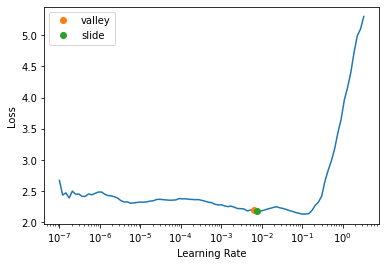

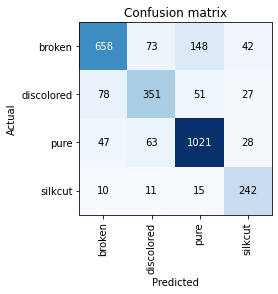

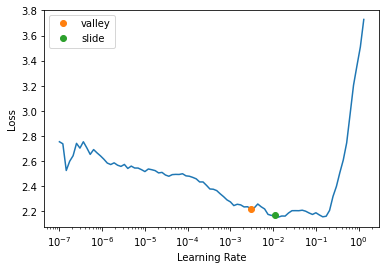

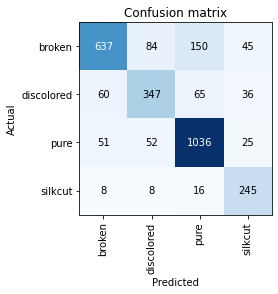

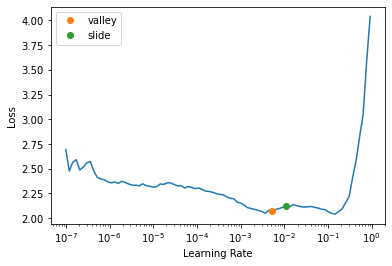

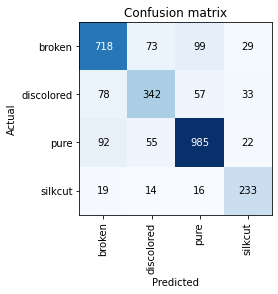

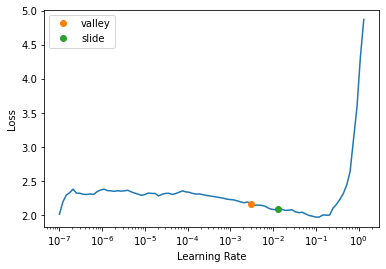

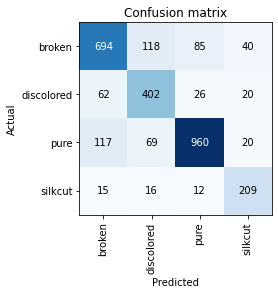

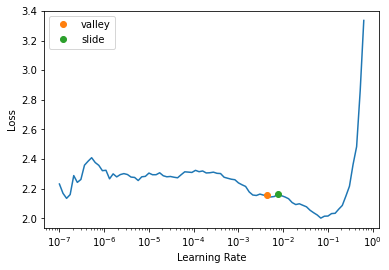

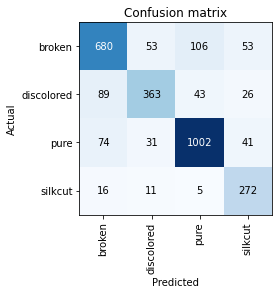

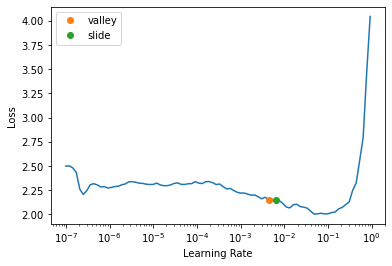

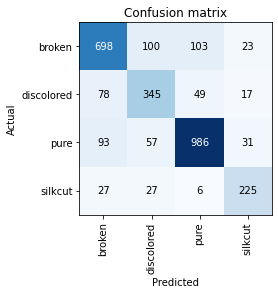

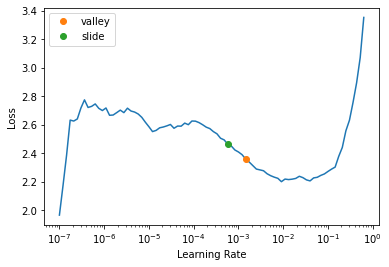

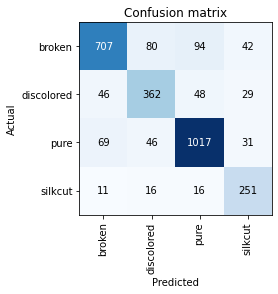

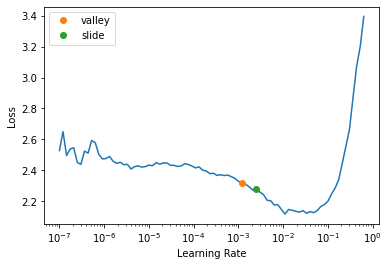

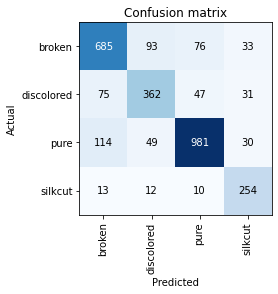

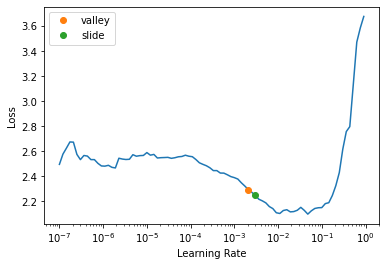

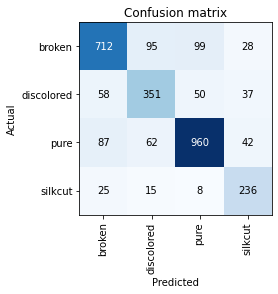

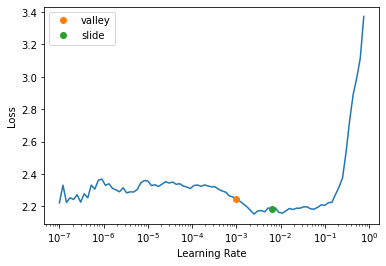

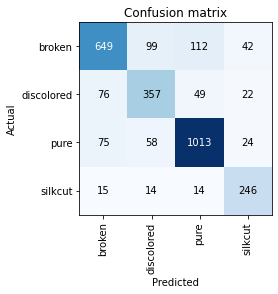

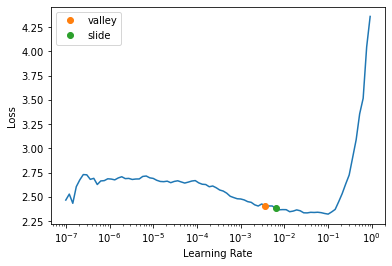

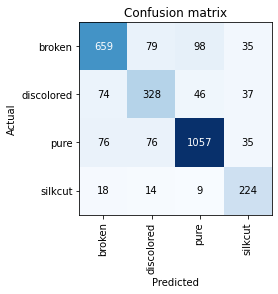

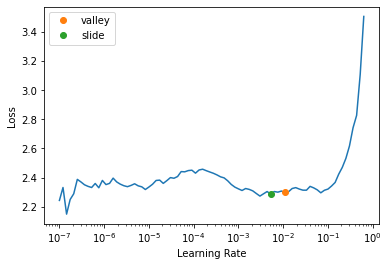

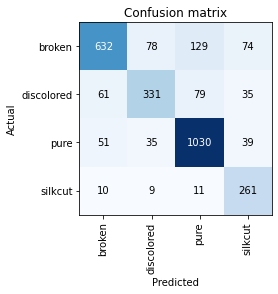

In [15]:
import gc

_item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
_epochs = 40
_patience=5
_min_delta=0.001
_early_stop=True

tta_res = []
valid_res = []
tta_valid_res = []

for arch, details in models.items():
    for batch, seed in details:
        print('---',arch," ",batch," ",seed,'---')
        learn, oversampled_dl_gen, tta_out = train_accum_es_over(arch,
            batch=champ_augmentations[batch],
            item=_item, new_seed=seed, accum=2,
            epochs=_epochs, patience=_patience,
            min_delta=_min_delta, early_stop=_early_stop)
        tta_res.append(tta_out)
        
        # Verify stats on validation set
        valid = learn.dls.valid
        preds,targs = learn.get_preds(dl=valid)
        valid_res.append(accuracy(preds,targs))
        
        # Check TTA statistics on validation set
        tta_preds,targs = learn.tta(dl=valid)
        tta_valid_res.append(accuracy(tta_preds,targs))
        
        # Plot confusion matrix
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        
        # Save Model
        model_filename = f'{arch}-{batch}-seed_{seed}-epochs_{_epochs}-es-oversample-expt_10'
        learn.save(model_filename)
        learn.export(model_filename+".pkl")
        
        # Save train/val sets
        oversampled_dl_gen.export(model_filename+"-data.pkl")

        # Attempt to clear GPU memory (as best we can)
        del(learn)
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

In [16]:
print(valid_res)
print(tta_valid_res)

[TensorBase(0.7930), TensorBase(0.7906), TensorBase(0.7951), TensorBase(0.7906), TensorBase(0.8087), TensorBase(0.7867), TensorBase(0.8157), TensorBase(0.7965), TensorBase(0.7885), TensorBase(0.7906), TensorBase(0.7916), TensorBase(0.7867)]
[TensorBase(0.7965), TensorBase(0.8136), TensorBase(0.8000), TensorBase(0.7972), TensorBase(0.8105), TensorBase(0.7930), TensorBase(0.8168), TensorBase(0.7941), TensorBase(0.7958), TensorBase(0.7913), TensorBase(0.7948), TensorBase(0.7881)]


This could take a while so let's save the result in case something goes wrong!

In [17]:
save_pickle('tta_res_experiment_10.pkl', tta_res)

## Ensembling

`Learner.tta` returns predictions and targets for each row.  We just want the predictions:

In [18]:
tta_prs = first(zip(*tta_res))

An ensemble simply refers to a model which is itself the result of combining a number of other models. The simplest way to do ensembling is to take the average of the predictions of each model:

In [19]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([3479, 4])

## Submission
Let's make an example dataloader to generate our vocab:

In [20]:
dls = ImageDataLoaders.from_df(trn_files, seed=21,
    path=csv_path, fn_col=2, label_col=3,
    valid_pct=0.2,
    item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border),
    batch_tfms=champ_augmentations['flip_rotate_smcrop256'],
    bs=64//2)

In [21]:
idxs = avg_pr.argmax(dim=1)
idxs

TensorBase([2, 2, 1,  ..., 2, 2, 2])

In [22]:
vocab = np.array(dls.vocab)
vocab

array(['broken', 'discolored', 'pure', 'silkcut'], dtype='<U10')

In [23]:
results = pd.Series(vocab[idxs], name="idxs")
results

0             pure
1             pure
2       discolored
3           broken
4           broken
           ...    
3474    discolored
3475    discolored
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

In [24]:
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
test.head()

,seed_id,view,image
0,2,top,test/00002.png
1,11,bottom,test/00011.png
2,13,top,test/00013.png
3,19,bottom,test/00019.png
4,27,bottom,test/00027.png


In [25]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

,seed_id,label
0,2,pure
1,11,pure
2,13,discolored
3,19,broken
4,27,broken
...,...,...
3474,17775,discolored
3475,17781,discolored
3476,17790,pure
3477,17794,pure


In [26]:
test.to_csv('submission_experiment_10.csv', index=False)
!head submission_experiment_10.csv

seed_id,label
2,pure
11,pure
13,discolored
19,broken
27,broken
30,pure
32,pure
41,pure
42,broken


In [ ]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission_experiment_10.csv', 'ensemble large models tested augmentation sets, early stopping and oversampling experiment 10', comp)

Won't submit from here.  This late in the competition we have to make the submissions count.  Will move trained networks over to kaggle and do a submission from there (inference only).